Cellrank analysis of metacells
----
Define trajectories on metacells. 

# Preliminaries

## Dependecy notebooks

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! which python

/home/icb/laura.martens/miniconda3/envs/cellrank/bin/python


Import packages

In [3]:
import anndata
import networkx as nx
import scanpy as sc
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cellrank as cr
from cellrank.tl.kernels import PseudotimeKernel, ConnectivityKernel, VelocityKernel
from cellrank.external.kernels import WOTKernel
from cellrank.tl.estimators import GPCCA

In [4]:
import scvelo as scv

In [5]:
scv.set_figure_params()

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [6]:
cr.logging.print_versions()

cellrank==1.5.1 scanpy==1.9.1 anndata==0.8.0 numpy==1.22.4 numba==0.55.2 scipy==1.9.0 pandas==1.4.3 pygpcca==1.0.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


In [7]:
cr.logging.print_version_and_date()

Running CellRank 1.5.1, on 2022-10-04 10:29.


## Setup paths

In [8]:
data_path = '/lustre/groups/ml01/workspace/laura.martens/moretti_colab'
save_path = os.path.join(data_path, 'scglue')
scvelo_path = os.path.join(data_path, 'scvelo')

## Load adata

In [9]:
adata = sc.read('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells.h5ad')

In [10]:
adata.obs.atac_match = adata.obs.atac_match.astype("category")

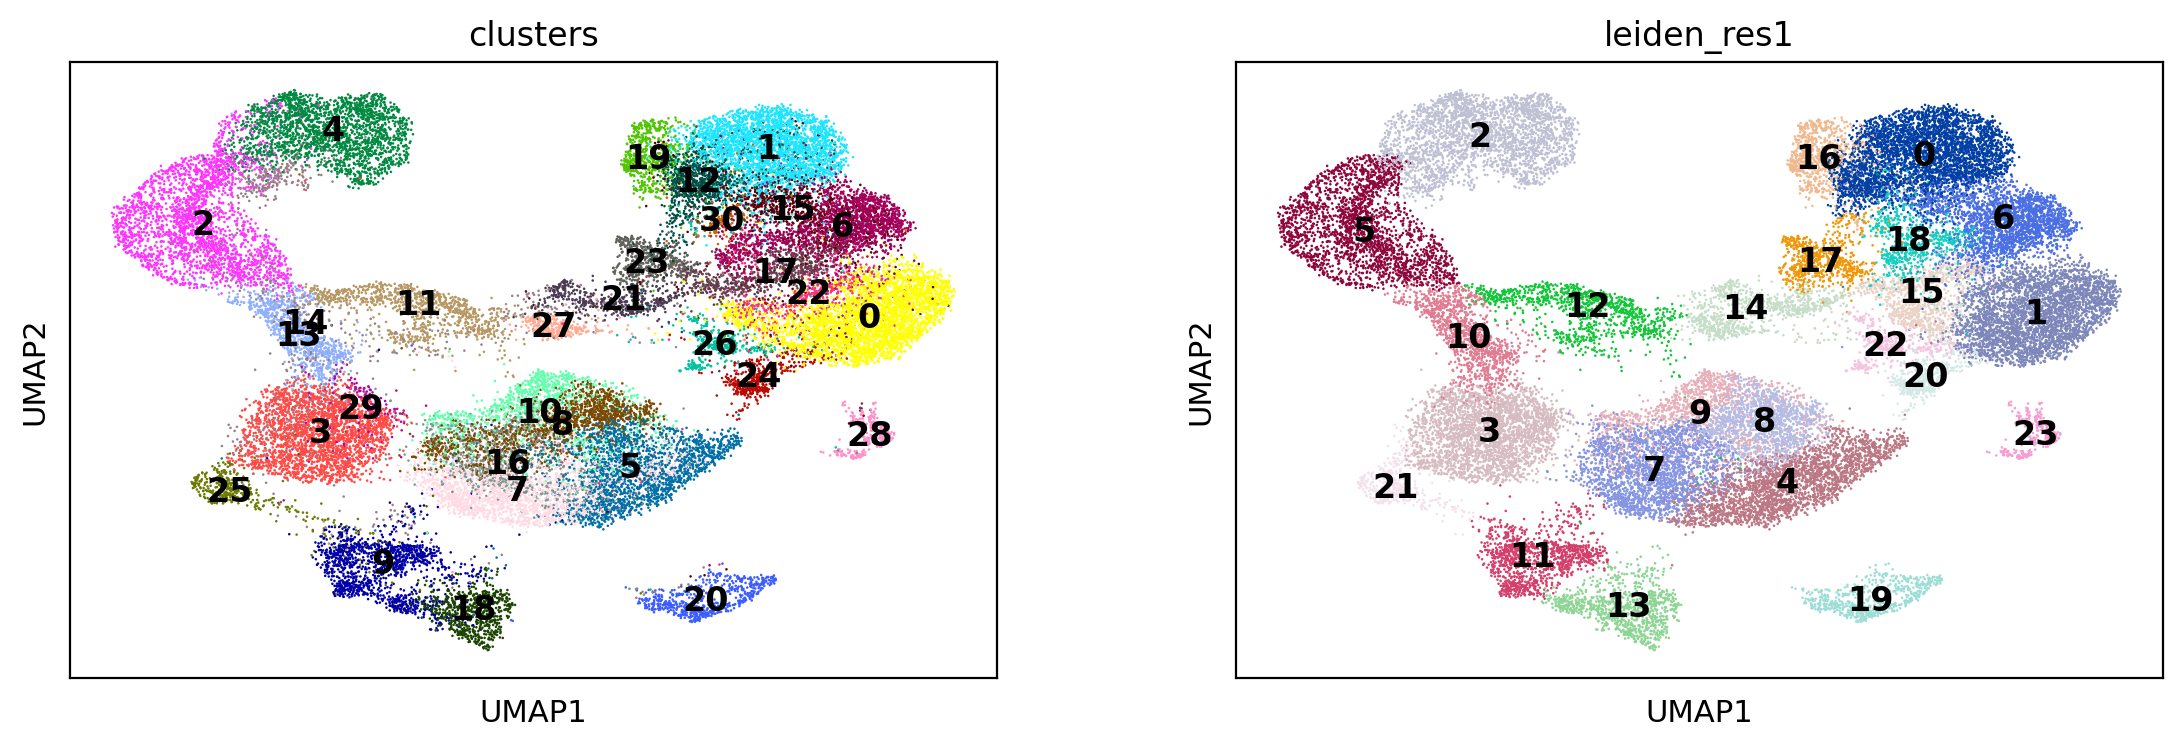

In [11]:
sc.pl.umap(adata, color=['clusters', 'leiden_res1'], legend_loc='on data')

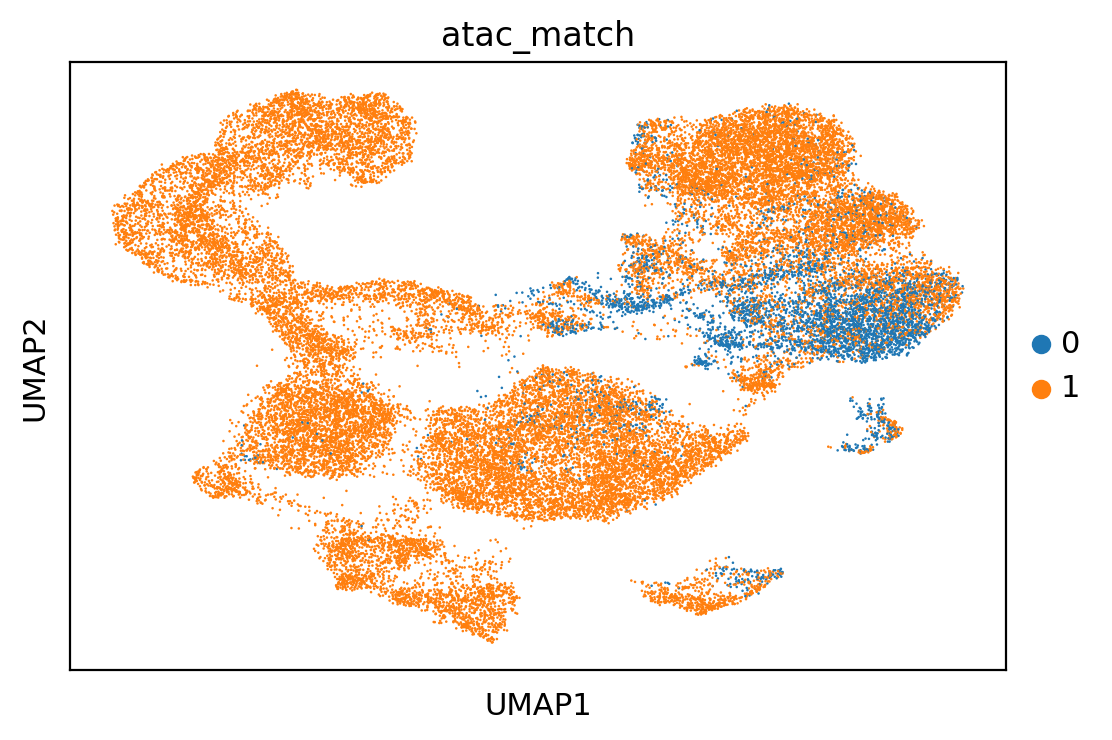

In [12]:
sc.pl.umap(adata, color=['atac_match'])

In [13]:
# Load scvelo results
scvelo_adata = sc.read(os.path.join(scvelo_path, 'scvelo_adata_non_dl.h5ad'))

In [14]:
scvelo_adata = scvelo_adata[adata.obs_names].copy()

In [15]:
scvelo_adata.obsm['X_umap'] = adata.obsm['X_umap']
scvelo_adata.obsm['X_glue'] = adata.obsm['X_glue']
scvelo_adata.obs = scvelo_adata.obs.join(adata.obs.leiden_res1)

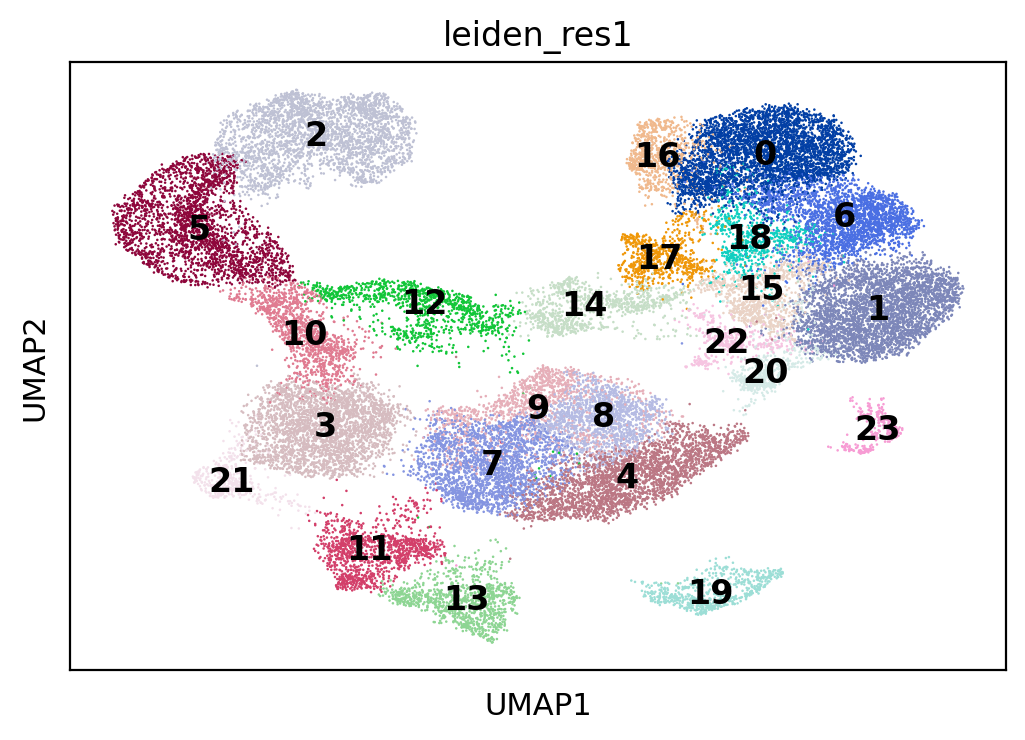

In [219]:
sc.pl.umap(scvelo_adata, color='leiden_res1', legend_loc='on data')

# Trajectory analysis

## Determine root cell

In [18]:
sc.tl.diffmap(adata)

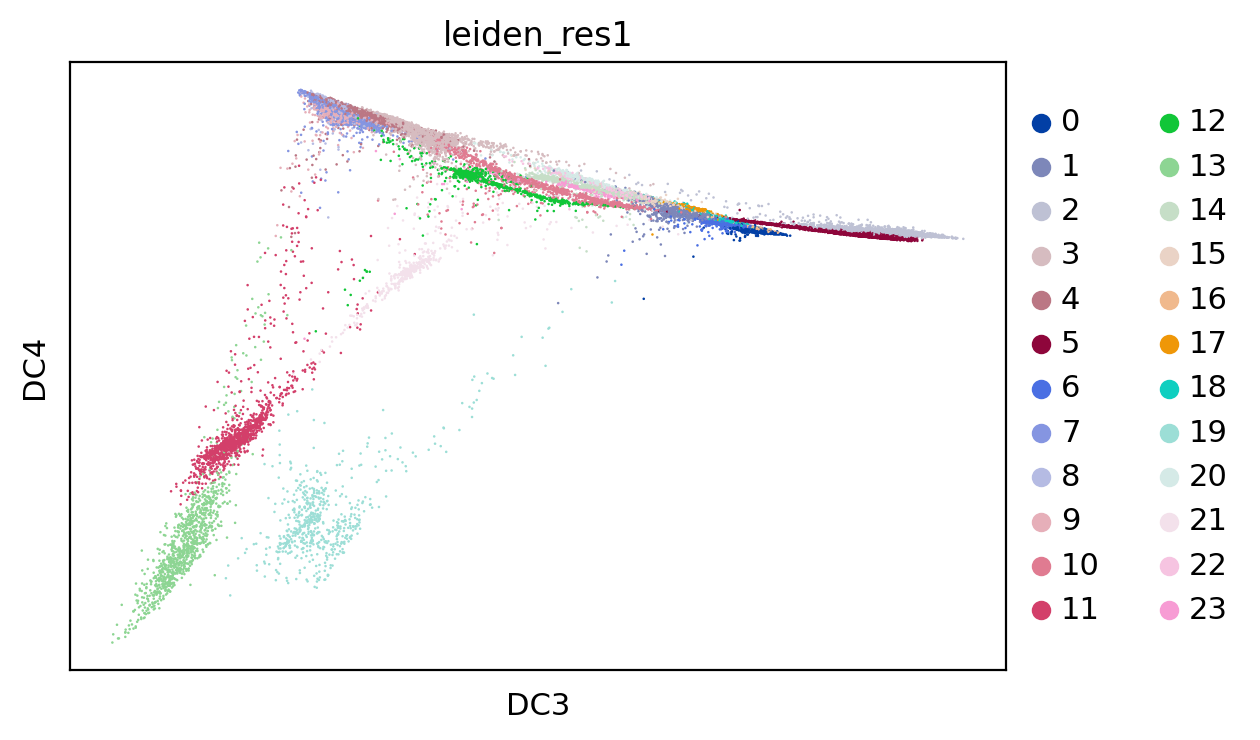

In [19]:
sc.pl.diffmap(adata, components='3,4', color='leiden_res1')

In [20]:
c1 = adata.obsm['X_diffmap'][:,2].argmax()
adata.uns['iroot'] = c1

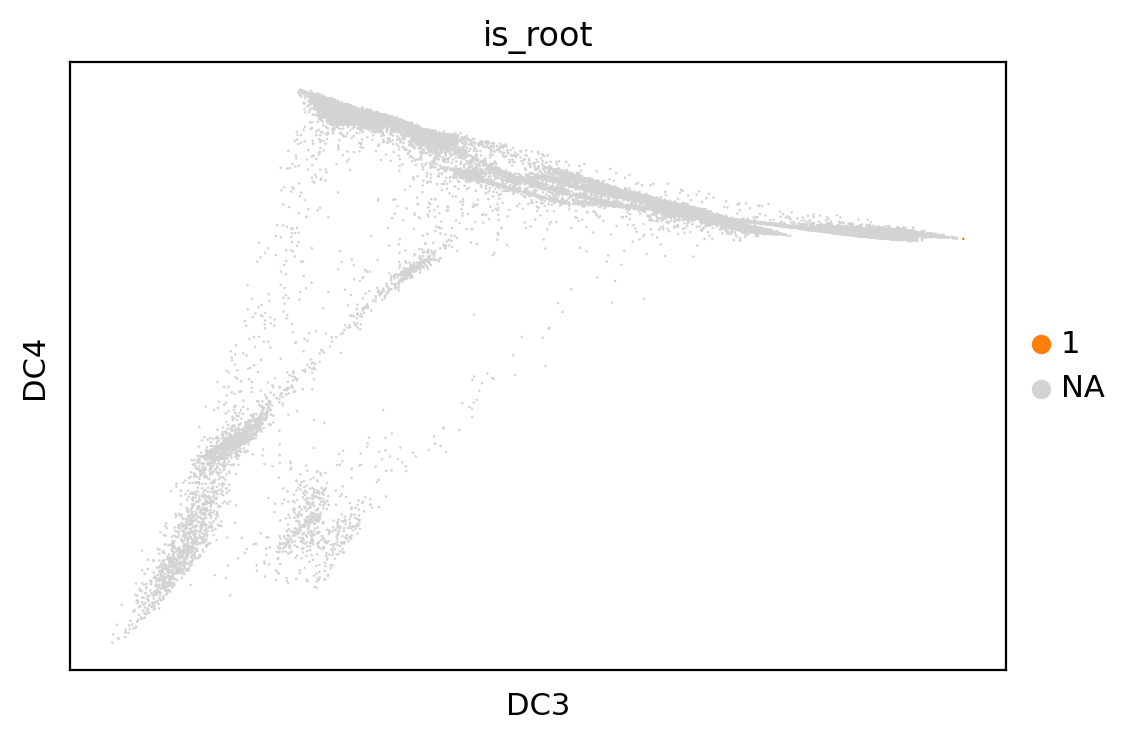

In [22]:
adata.obs['is_root'] = ['1' if idx==adata.obs_names[c1] else '0' for idx in adata.obs_names]
sc.pl.diffmap(adata, color='is_root', components='3,4', frameon=True, groups='1')

## Compute pseudotime

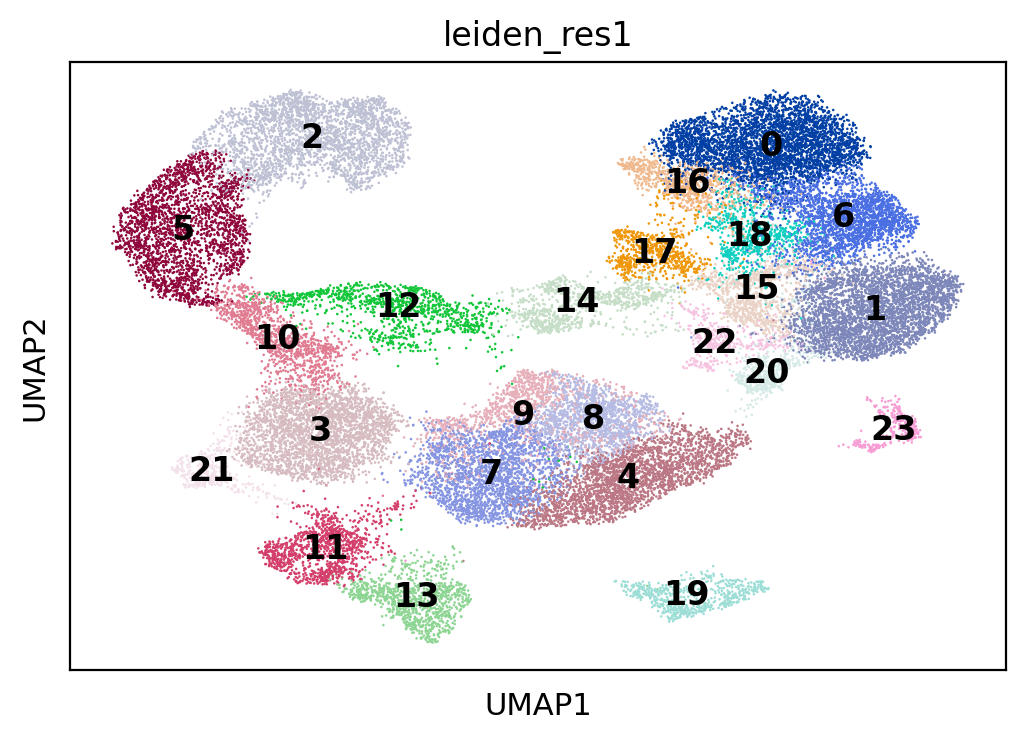

In [23]:
sc.pl.umap(adata, color='leiden_res1', legend_loc='on data')

## Run palantir

In [24]:
import palantir
import pandas as pd

In [25]:
# Run diffusion maps
emb_projections = pd.DataFrame(adata.obsm['X_glue'], index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(emb_projections, n_components=10)



Determing nearest neighbor graph...


In [26]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [27]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)

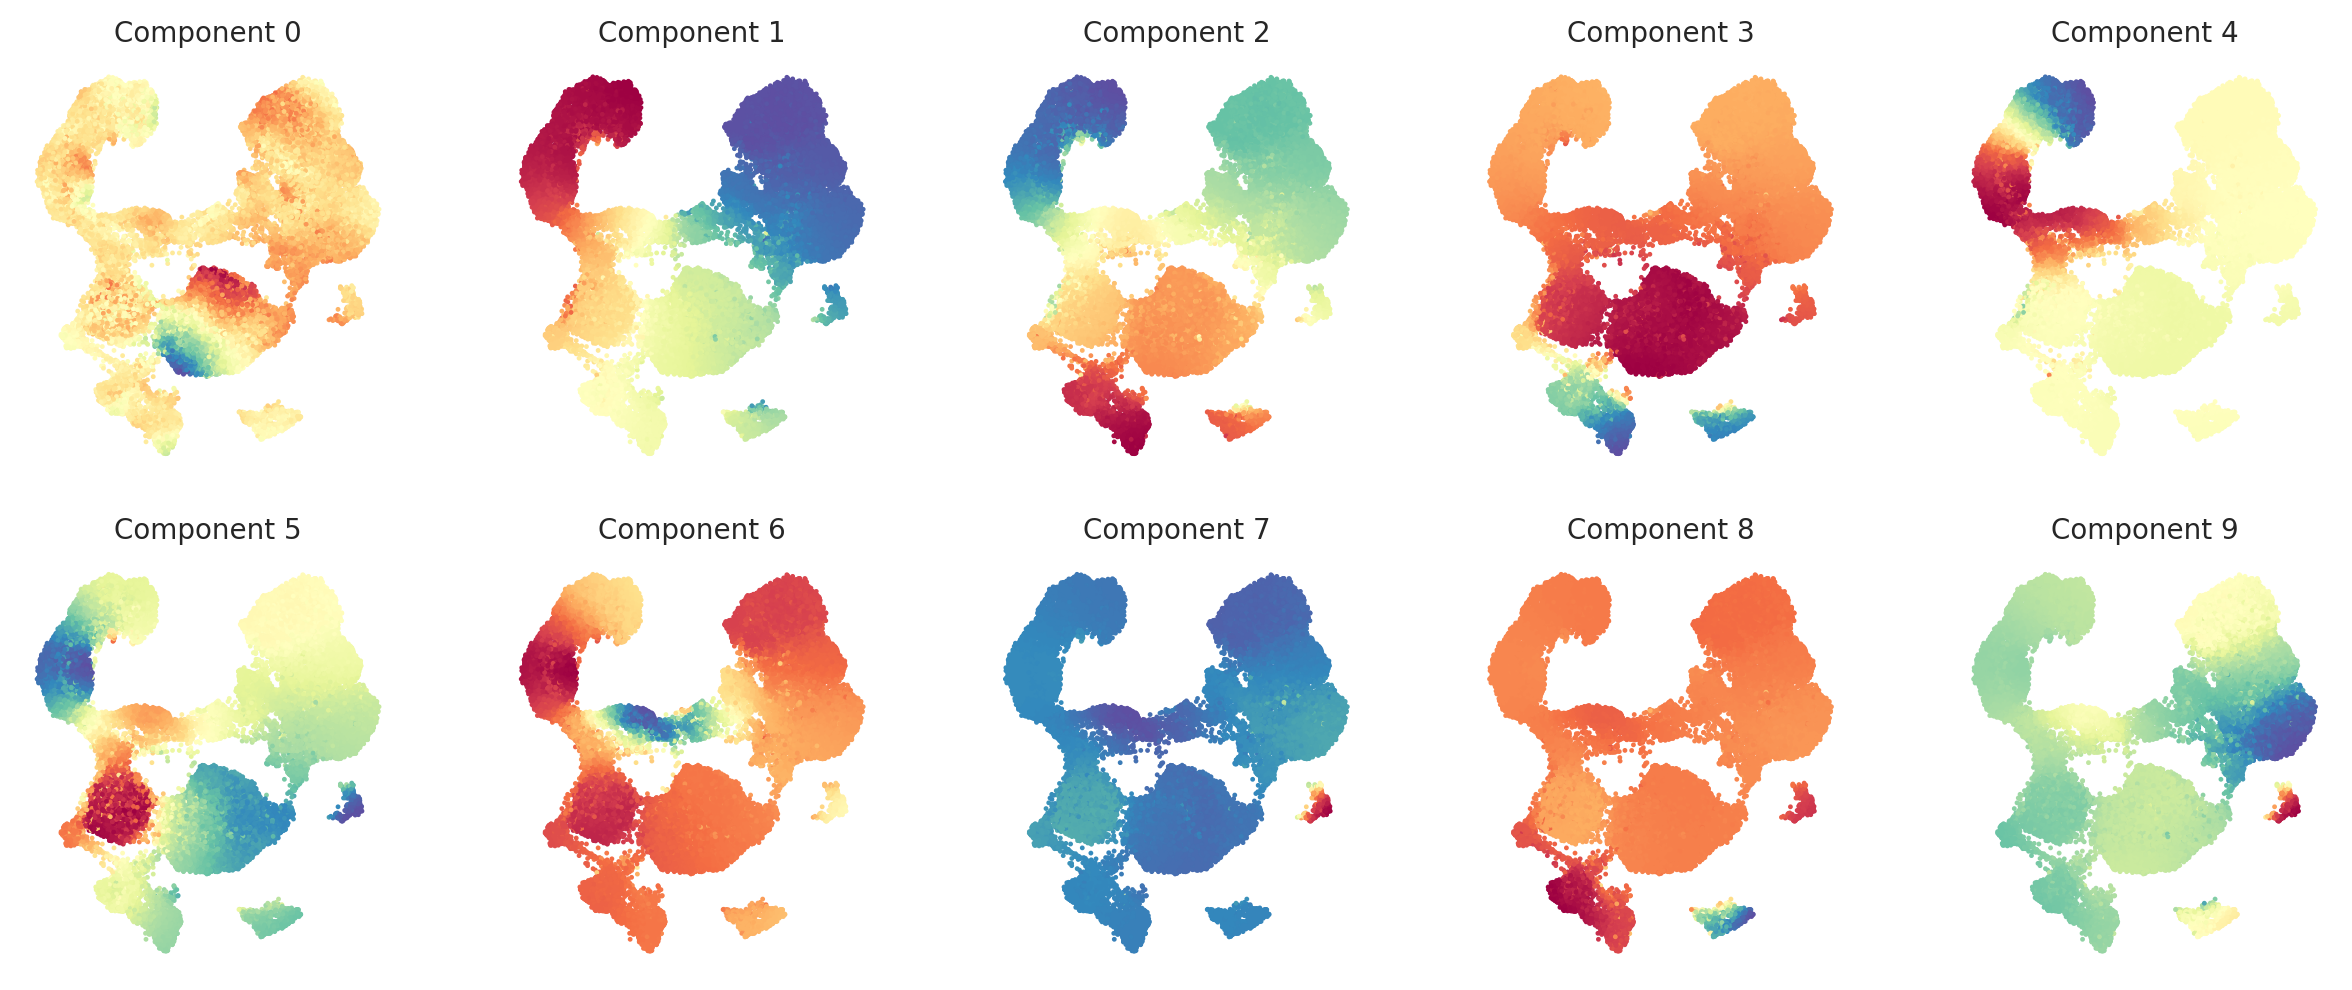

In [28]:
palantir.plot.plot_diffusion_components(umap, dm_res)


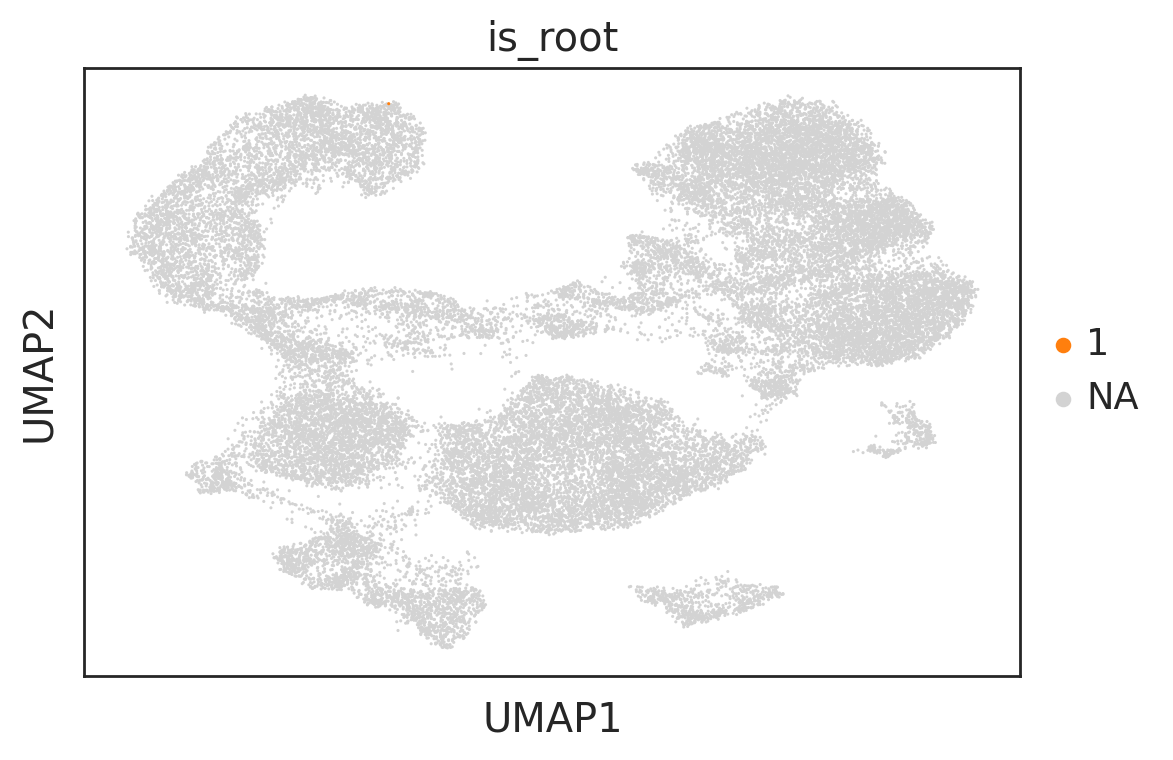

In [29]:
sc.pl.umap(adata, color='is_root', size=5, groups='1')

In [30]:
start_cell = adata.obs_names[adata.uns['iroot']]

In [31]:
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.03669191201527913 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Time for shortest paths: 0.6652811249097188 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


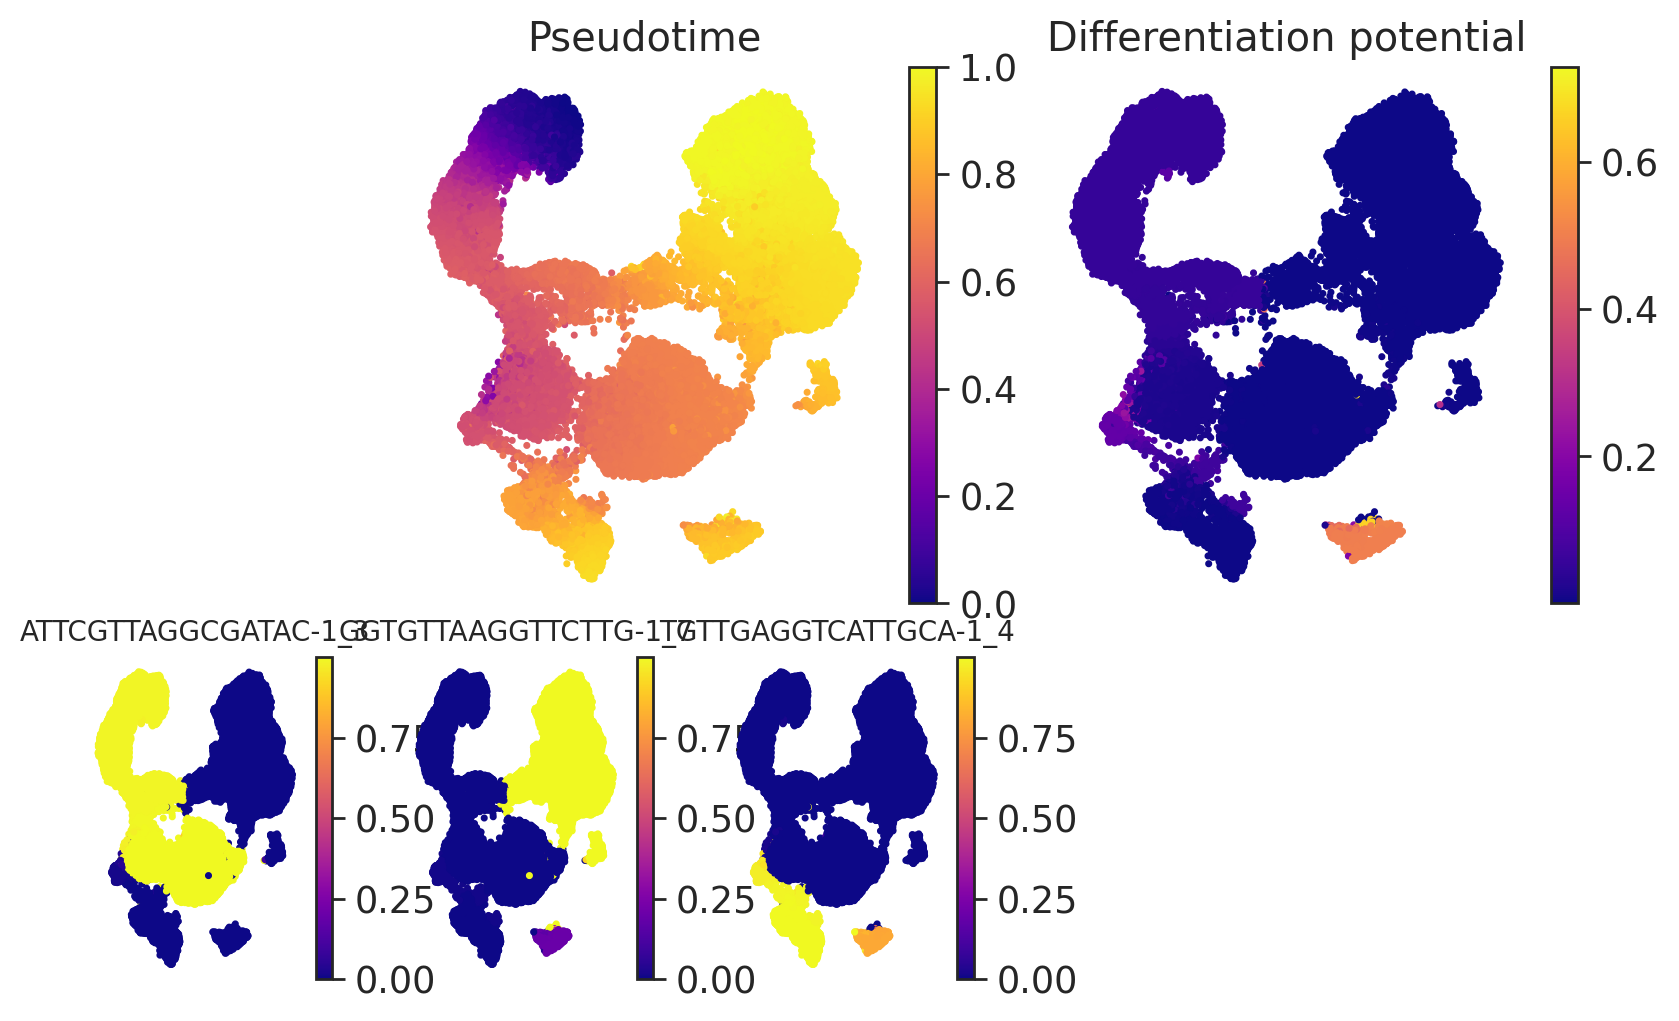

In [32]:
palantir.plot.plot_palantir_results(pr_res, umap)

In [89]:
adata.obs['pr_pseudotime'] = pr_res.pseudotime

In [90]:
scvelo_adata.obs['pr_pseudotime'] = pr_res.pseudotime

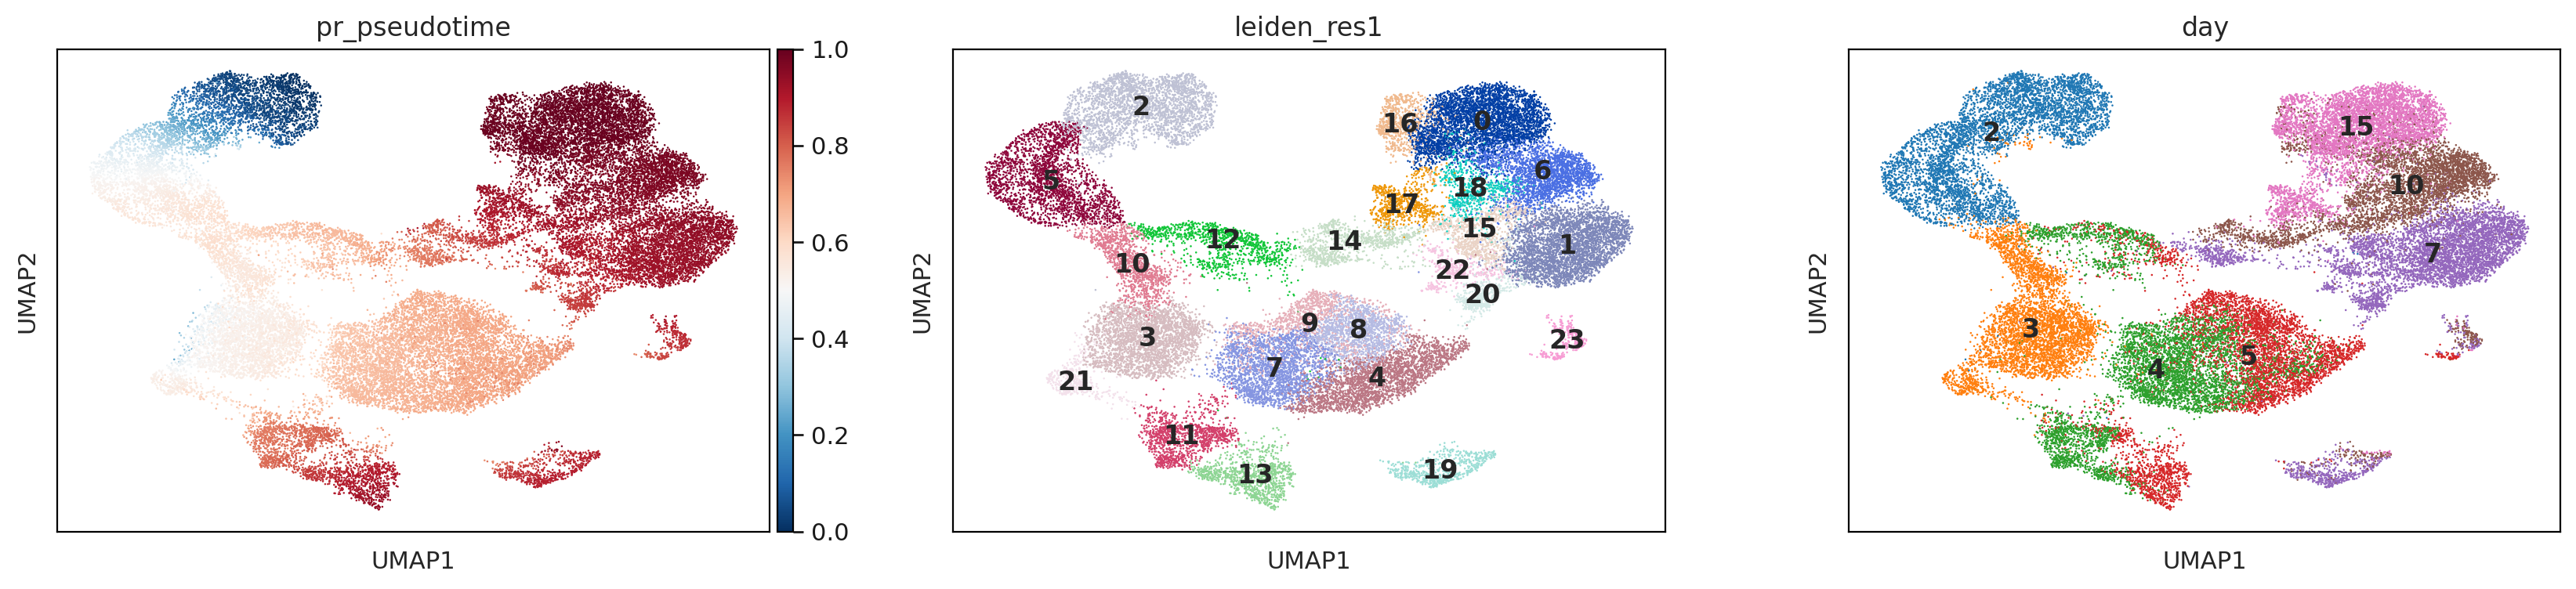

In [91]:
sc.pl.umap(adata, color=['pr_pseudotime', 'leiden_res1', 'day'], legend_loc='on data')

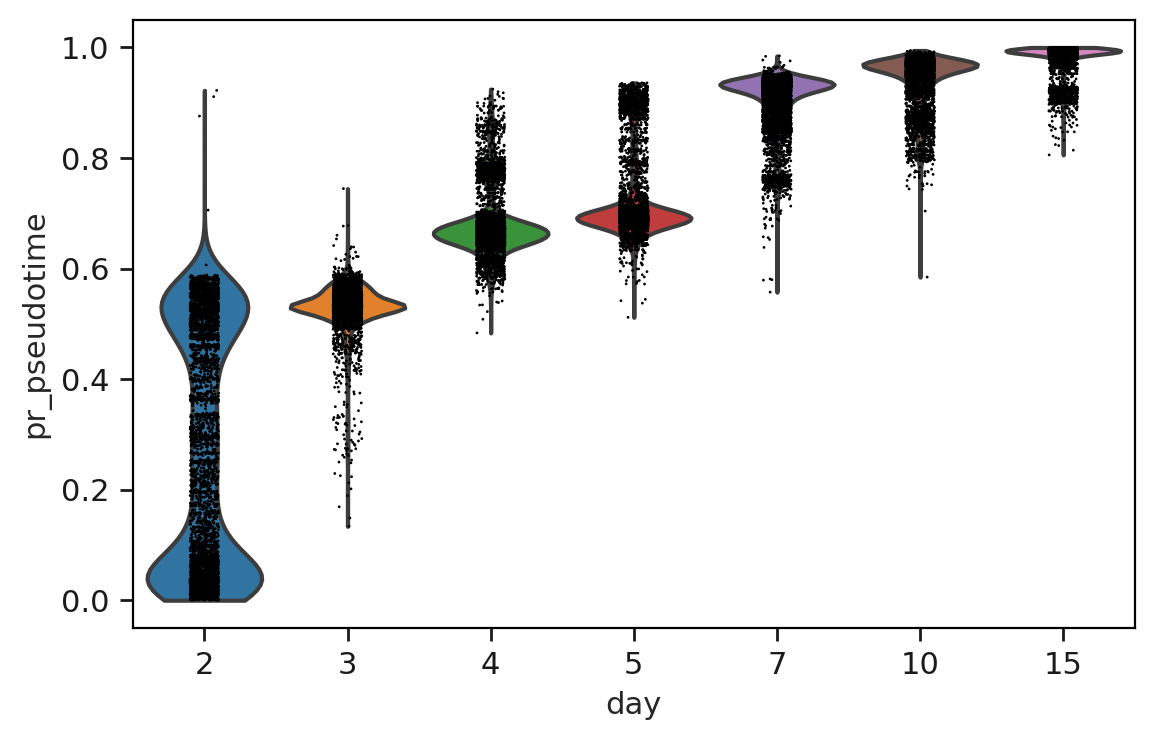

In [92]:
sc.pl.violin(adata, keys='pr_pseudotime', groupby='day')

# Run cellrank

In [37]:
pk = PseudotimeKernel(adata, time_key='pr_pseudotime') 

In [38]:
pk.compute_transition_matrix()

  0%|          | 0/35499 [00:00<?, ?cell/s]

<PseudotimeKernel>

In [41]:
vk = VelocityKernel(scvelo_adata)

In [42]:
vk.compute_transition_matrix()

  0%|          | 0/35499 [00:00<?, ?cell/s]

  0%|          | 0/35499 [00:00<?, ?cell/s]

<VelocityKernel>

In [43]:
k = 0.3*vk + 0.7*pk

In [44]:
g = GPCCA(k)
print(g)

GPCCA[n=35499, kernel=((0.3 * <VelocityKernel[softmax_scale=17.36, mode=deterministic, seed=27139, scheme=<CorrelationScheme>]>) + (0.7 * <PseudotimeKernel[dnorm=False, scheme=hard, frac_to_keep=0.3]>))]


In [ ]:
g.compute_schur(n_components=30)

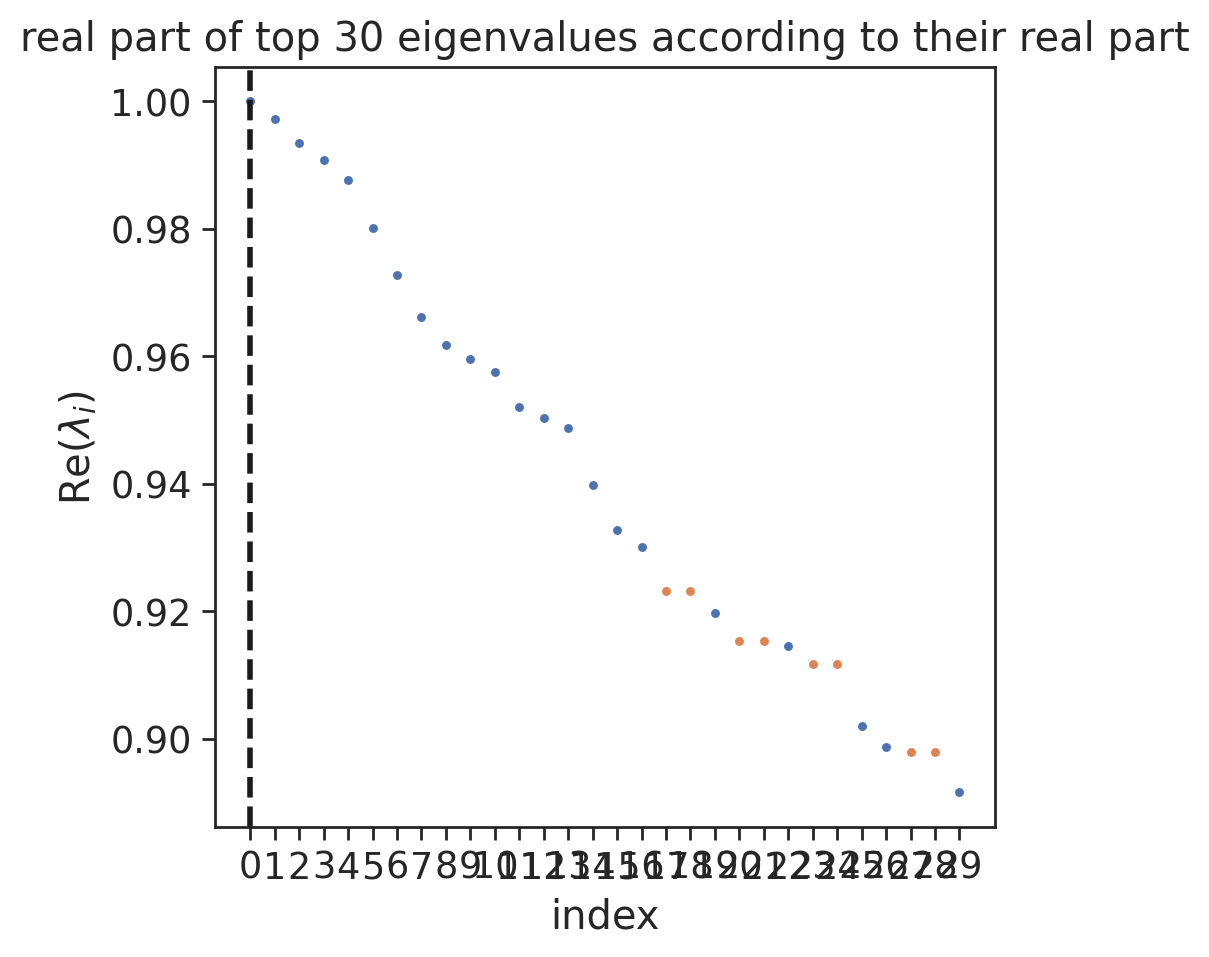

In [46]:
g.plot_spectrum(real_only=True)

In [47]:
g.compute_macrostates(n_states=15, cluster_key="leiden_res1")

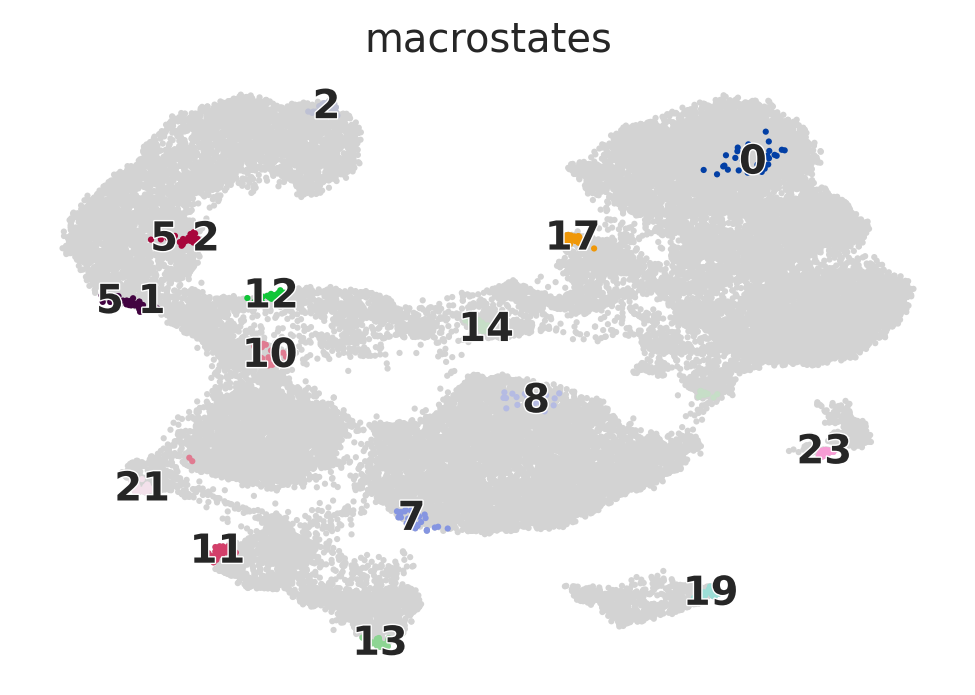

In [48]:
g.plot_macrostates(discrete=True, size=20)

In [50]:
g.set_terminal_states_from_macrostates(
    [
        '17',
        '0',
        '23',
        '19',
        '13'
        
])

In [51]:
g.rename_terminal_states({'0': "Cardiomyocyte", "23": "EC", "13": "Endoderm", '19': "Endoderm_2",'17':"Epicardial"}) #'23': "Endoderm", 

In [23]:
g.compute_absorption_probabilities(solver='gmres', use_petsc=True)

  0%|          | 0/5 [00:00<?, ?/s]

In [53]:
g.write(os.path.join(data_path, 'cellrank', 'g'))

## Analyse cellrank results

In [218]:
g = GPCCA.read(os.path.join(data_path, 'cellrank', 'g.pickle'))

In [22]:
g.adata = adata.copy()

### Absorption probabilities

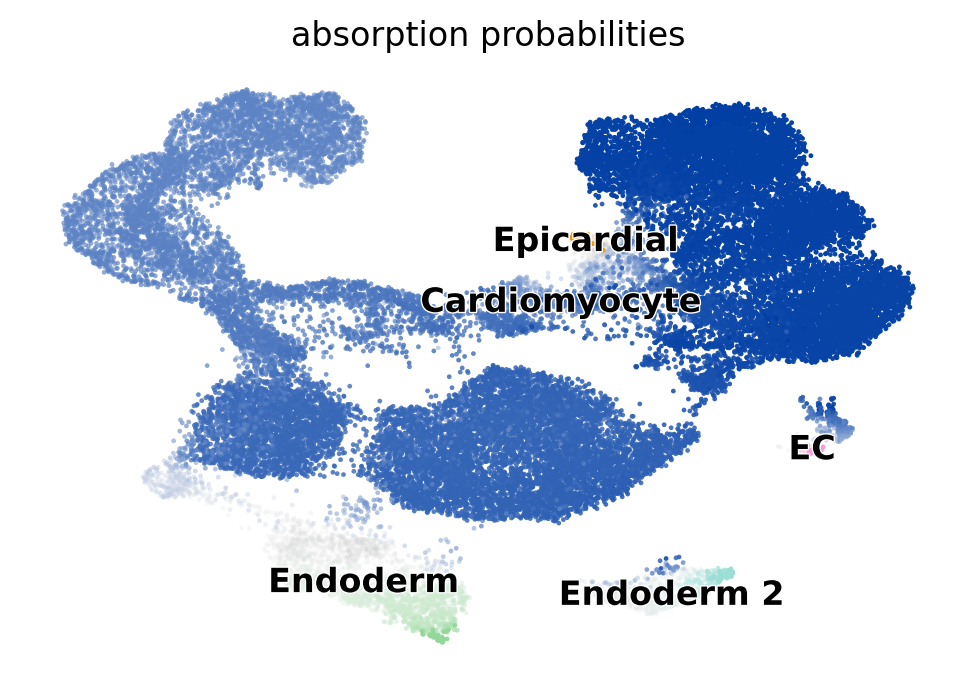

In [25]:
g.plot_absorption_probabilities(same_plot=True, basis='umap', vmax=0.5)

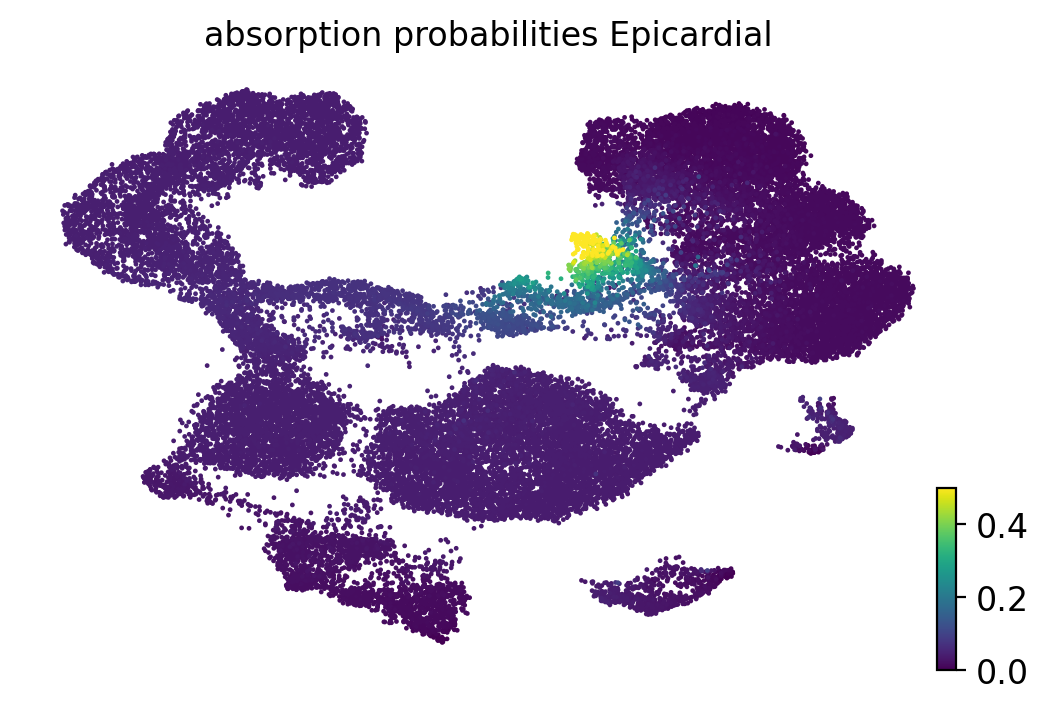

In [26]:
g.plot_absorption_probabilities(same_plot=True, basis='umap', states=['Epicardial'], vmax=0.5)

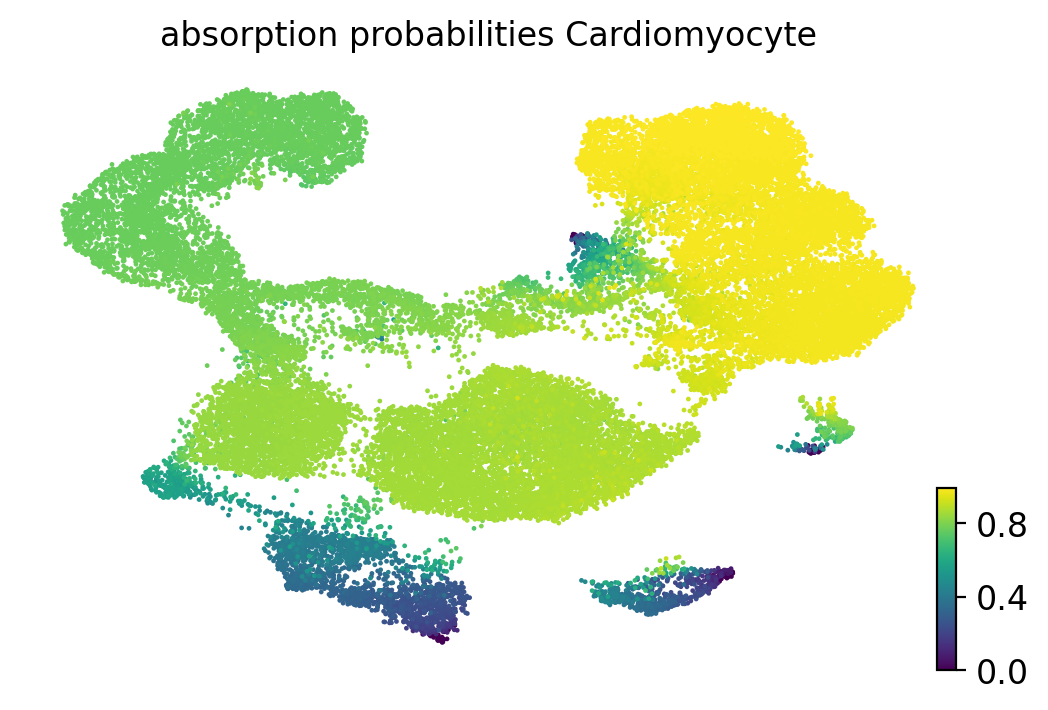

In [28]:
g.plot_absorption_probabilities(same_plot=True, basis='umap', states=['Cardiomyocyte'])

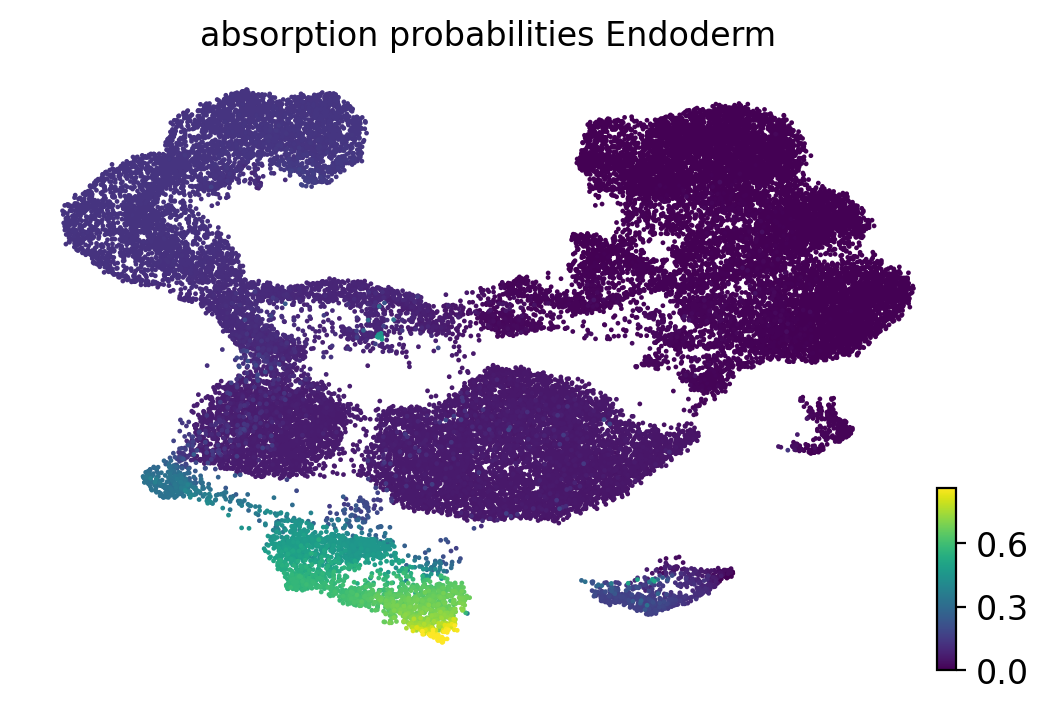

In [29]:
g.plot_absorption_probabilities(same_plot=True, basis='umap', states=['Endoderm'])

## Save data

In [ ]:
g_atac.write(os.path.join(data_path, 'cellrank', 'g_atac'))

In [116]:
g.write(os.path.join(data_path, 'cellrank', 'g'))